# Analyzing Syrian Civil War Casualties



*by Tyler Basa*

# Introduction

I want to analyze recorded Syrian Civil War Deaths and check certain relationships between categories. For example, I wanted to check the relationship between deaths of certain factions and civilains, combined with the locations or time of their deaths.

https://data.world/polymathic/casualties-of-the-syrian-civil-war

In [164]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from sklearn.linear_model import LinearRegression
from statsmodels.formula.api import ols

Having downloaded the data for this tutorial, let's first read the data and preview some of the rows. This dataset is an overview of recorded individuals who were killed during the Syrian Civil War.

In [23]:
data = pd.read_csv("Syr.csv")
data

,name,status,gender,province,birthplace,deathdate,deathcause,actor
0,Ahmad Tomeh,Civilian,Adult - Male,Homs,Telbeiseh,2019-02-18,Detention - Torture,Syrian government and affiliated militias
1,Bashar al-Haj Ali,Civilian,Adult - Male,Homs,Telbeiseh,2019-02-18,Detention - Torture,Syrian government and affiliated militias
2,Hiba Riad Janoud,Civilian,Adult - Female,Hama,Tweni,2019-02-17,Shelling,Syrian government and affiliated militias
3,Zahra Khaled al-Dabous,Civilian,Adult - Female,Hama,Zakat village,2019-02-17,Shelling,Russian troops
4,Eyad Melhem,Civilian,Child - Male,Hama,Lattamna,2019-02-16,Shelling,Syrian government and affiliated militias
...,...,...,...,...,...,...,...,...
168421,Anas Al-Bakour,Civilian,Adult - Male,Hama,Sahl Al-Ghab: Kafarnboudeh,2011-09-12,Shooting,NaN
168422,Ibrahim Mohammad Al-Suleiman,Civilian,Adult - Male,Idlib,Billion,2011-09-12,Shooting,NaN
168423,Mohamad Ahmad Al-Yousef Al-Jarban,Civilian,Adult - Male,Hama,Soran - Hama,2011-07-31,Shooting,NaN
168424,Osama Mahmoud Haded,Civilian,Adult - Male,Homs,Talbiseh,2011-04-28,Shooting,NaN


We see that some of the values are NaN in the tail of the dataset. For our analysis, the main categories we are looking for is a relationship are between status, gender, province, date of death, cause of death, and actor categories. To find how many different types of values are between them, let's print all the unique values excluding date of death. Let's also check the datatypes of the columns, especially to see if the date of death is in date time.

In [24]:
print("Gender Categories:")
print(data.gender.unique())
print("\n Province Categories:")
print(data.province.unique())
print("\n Cause of Death Categories:")
print(data.deathcause.unique())
print("\n Perpetrator Categories:")
print(data.actor.unique())
print("\n Status Categories:")
print(data.status.unique())
print("\n Data Types")
print(data.dtypes)

Gender Categories:
['Adult - Male' 'Adult - Female' 'Child - Male' 'Child - Female']

 Province Categories:
['Homs' 'Hama' 'Aleppo' 'Idlib' 'Unknown' 'Damascus' 'Raqqa' 'Daraa'
 'Deir Ezzor' 'Hasakeh' 'Lattakia' 'Other Nationalities'
 'Damascus Suburbs' 'Sweida' 'Quneitra' 'Tartous']

 Cause of Death Categories:
['Detention - Torture' 'Shelling' 'Explosion' 'Shooting' 'Other' 'Unknown'
 'Warplane shelling' 'Detention - Execution'
 'Un-allowed to seek Medical help' 'Siege' 'Field Execution'
 'Kidnapping - Execution' 'Kidnapping - Torture'
 'Kidnapping - Torture - Execution' 'Detention - Torture - Execution'
 'Chemical and toxic gases']

 Perpetrator Categories:
['Syrian government and affiliated militias' 'Russian troops'
 'Not identified' 'Al-Nusra Front' 'International coalition forces'
 'The organization of the Islamic State in Iraq and the Levant - ISIS'
 'Self administration forces' 'Armed opposition groups' nan]

 Status Categories:
['Civilian' 'Non-Civilian']

 Data Types
name   

# Notes on the different categories

The category values are straight forward for the most part, but Actor categories interestingly have nan values. Whether the reason, we can assume this means the perpetrators were unidentified, but there is already a category for that called "Not identified". Despite looking like it's in datetime format, the date of deaths column is not actually in the type and all columns are "object" dtypes. Lets fill in the nan values in the "actor" column to "not identified", convert the "deathdate" column to datetime, and convert the other columns to string.

In [34]:
data['actor'] = data['actor'].fillna('Not identified') # Fill in all nan values in actor with "not identified"
data['deathdate']= pd.to_datetime(data['deathdate'])
data['name'] = data['name'].astype('str') 
data['status'] = data['status'].astype('str')
data['gender'] = data['gender'].astype('str') 
data['province'] = data['province'].astype('str') 
data['birthplace'] = data['birthplace'].astype('str') 
data['deathcause'] = data['deathcause'].astype('str') 
data['actor'] = data['actor'].astype('str') 
data.tail() 

,name,status,gender,province,birthplace,deathdate,deathcause,actor
168421,Anas Al-Bakour,Civilian,Adult - Male,Hama,Sahl Al-Ghab: Kafarnboudeh,2011-09-12,Shooting,Not identified
168422,Ibrahim Mohammad Al-Suleiman,Civilian,Adult - Male,Idlib,Billion,2011-09-12,Shooting,Not identified
168423,Mohamad Ahmad Al-Yousef Al-Jarban,Civilian,Adult - Male,Hama,Soran - Hama,2011-07-31,Shooting,Not identified
168424,Osama Mahmoud Haded,Civilian,Adult - Male,Homs,Talbiseh,2011-04-28,Shooting,Not identified
168425,Nayef al-Daher,Civilian,Adult - Male,Homs,Talbiseh,2011-03-29,Shooting,Not identified


# Analysis

Let's get some basic data. First let's compile the amount of casualties and differentiate them by gender first.

In [145]:
data_genderStat = data.groupby(['gender']).name.agg('count').to_frame('count').reset_index()
data_genderStat

,gender,count
0,Adult - Female,13695
1,Adult - Male,132889
2,Child - Female,7191
3,Child - Male,14651


Let's turn that into a pie chart

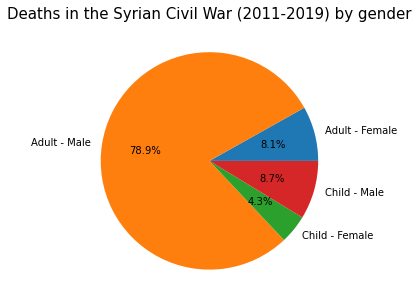

In [99]:
plt.figure(figsize=(5,5)) 
plt.title('Deaths in the Syrian Civil War (2011-2019) by gender', fontsize=15)
plt.pie(data_genderStat['count'],labels=data_genderStat['gender'],autopct='%1.1f%%')
plt.show()

We can see here that most casualties in the Syrian Civil War are Adult males, with Male children taking second place, with females taking second place. We can assume that the reason for these proportions are because most combatants in the war are Adult males. To test that theory out lets make a plot that compares between gender and status with two pie charts. One shows the proportion of gender between civilians, and another between non-civilians.

In [141]:
StatusGender = data.groupby(['status','gender']).name.agg('count').to_frame('count').reset_index()

Civilians = StatusGender.loc[StatusGender['status'] == "Civilian"]
NonCivilians = StatusGender.loc[StatusGender['status'] == "Non-Civilian"]

StatusGender

,status,gender,count
0,Civilian,Adult - Female,13656
1,Civilian,Adult - Male,84405
2,Civilian,Child - Female,7189
3,Civilian,Child - Male,14287
4,Non-Civilian,Adult - Female,39
5,Non-Civilian,Adult - Male,48484
6,Non-Civilian,Child - Female,2
7,Non-Civilian,Child - Male,364


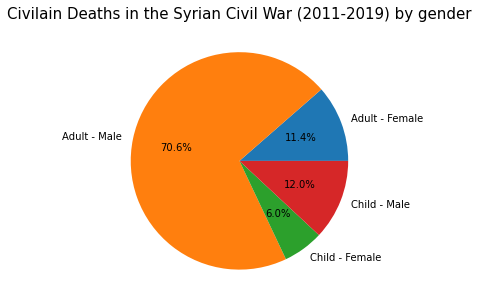

In [131]:
plt.figure(figsize=(5,5)) 
plt.title('Civilain Deaths in the Syrian Civil War (2011-2019) by gender', fontsize=15)
plt.pie(Civilians['count'],labels=Civilians['gender'],autopct='%1.1f%%')
plt.show()

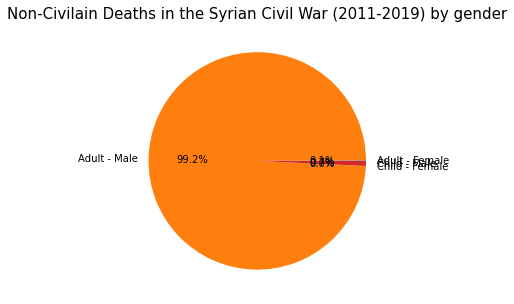

In [133]:
plt.figure(figsize=(5,5)) 
plt.title('Non-Civilain Deaths in the Syrian Civil War (2011-2019) by gender', fontsize=15)
plt.pie(NonCivilians['count'],labels=NonCivilians['gender'],autopct='%1.1f%%')
plt.show()

We can see that most of the deaths have affected males. While almost 100% of non-civilian deaths have been men, the table shows that the civilian body count vastly outnumbers the non-civilian body count.

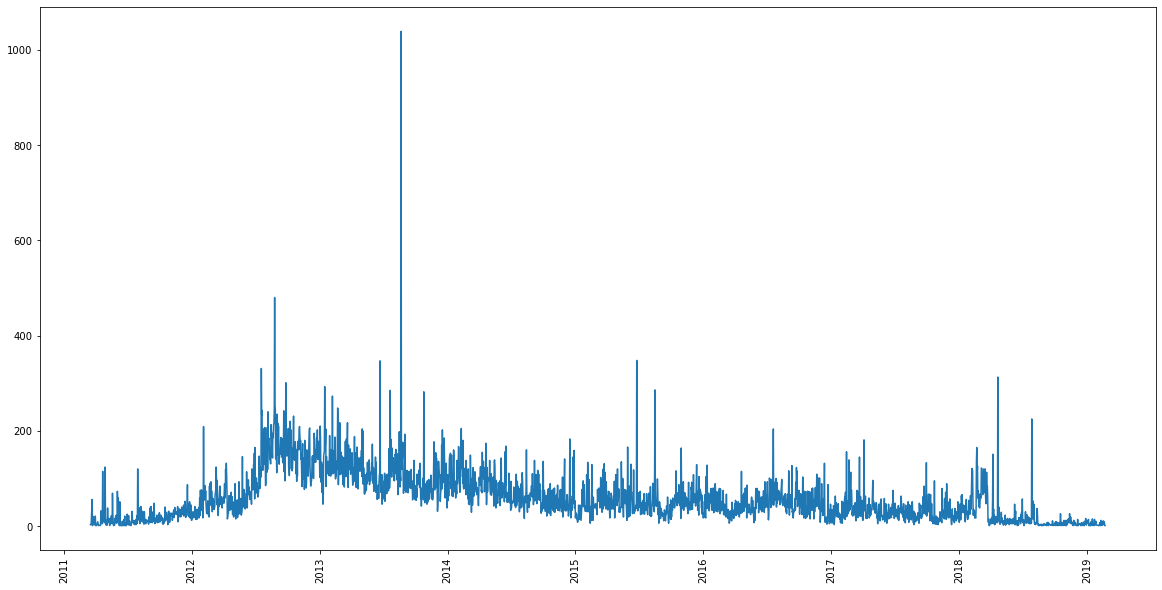

In [146]:
data_timeplot = data.groupby(['deathdate']).name.agg('count').to_frame('count').reset_index()

# plot line graph
plt.figure(figsize=(20,10)) 
plt.plot(data_timeplot['deathdate'], data_timeplot['count'])
plt.xticks(rotation='vertical')
plt.show()


What we can observe from our eyes are two things. One, the number of deaths peaked between in the middle of 2012 to 2014. After that, the number of deaths seem to be in a slow but somewhat steady decline

In [96]:
data_timeplot = data_timeplot.sort_values('count', ascending=False)
data_timeplot.head()

,deathdate,count
870,2013-08-21,1039
509,2012-08-25,480
1543,2015-06-25,348
810,2013-06-22,347
471,2012-07-18,331


We check the date of August 21st, 2013 online and information shows thats the date of the Ghouta chemical attack allegedly by Syrian government forces against civilians. To visualize the effect of the attack, we can make three pie charts. One based on the statuses of casualties on that day, one based on the actors of those casualties aka perpetrators, and another based on the cause of death.

In [111]:
GhoutaStats = data.loc[data['deathdate'] == "2013-08-21"]
GhoutaStats.head()

,name,status,gender,province,birthplace,deathdate,deathcause,actor
41857,Ahmad Abdulhamed Balkash,Non-Civilian,Adult - Male,Damascus Suburbs,Mouadamiyeh,2013-08-21,Chemical and toxic gases,Syrian government and affiliated militias
41858,Tahseen Zoheir Mohammad Sendyan,Civilian,Adult - Male,Damascus,Mazzeh,2013-08-21,Chemical and toxic gases,Syrian government and affiliated militias
41859,Abd al-Salam Ahmad Gazal,Non-Civilian,Adult - Male,Idlib,Taftanaz,2013-08-21,Shelling,Syrian government and affiliated militias
41860,Fayez Dyab,Civilian,Adult - Male,Hama,Al-Ghab Plain: Ramla village,2013-08-21,Shooting,Syrian government and affiliated militias
41861,Ahmad Abo al-Omer,Civilian,Adult - Male,Hama,Karim village,2013-08-21,Shooting,Syrian government and affiliated militias


In [149]:
# Compare by Status
GhoutaStatsOne = GhoutaStats.groupby(['status']).name.agg('count').to_frame('count').reset_index()

# Compare by actor/perpetrator
GhoutaStatsTwo = GhoutaStats.groupby(['actor']).name.agg('count').to_frame('count').reset_index()

# Compare by cause of death
GhoutaStatsThree = GhoutaStats.groupby(['deathcause']).name.agg('count').to_frame('count').reset_index()

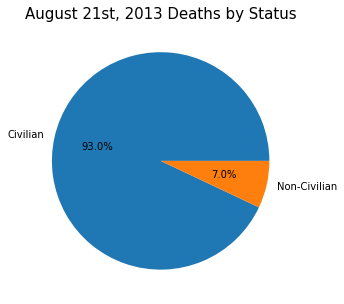

In [148]:
plt.figure(figsize=(5,5)) 
plt.title('August 21st, 2013 Deaths by Status', fontsize=15)
plt.pie(GhoutaStatsOne['count'],labels=GhoutaStatsOne['status'],autopct='%1.1f%%')
plt.show()

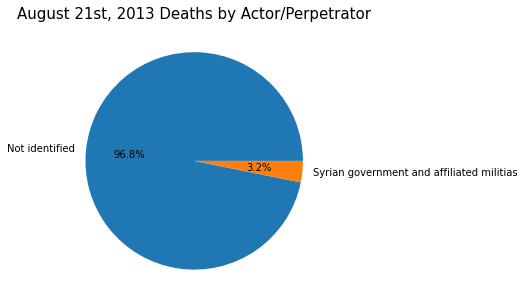

In [150]:
plt.figure(figsize=(5,5)) 
plt.title('August 21st, 2013 Deaths by Actor/Perpetrator', fontsize=15)
plt.pie(GhoutaStatsTwo['count'],labels=GhoutaStatsTwo['actor'],autopct='%1.1f%%')
plt.show()

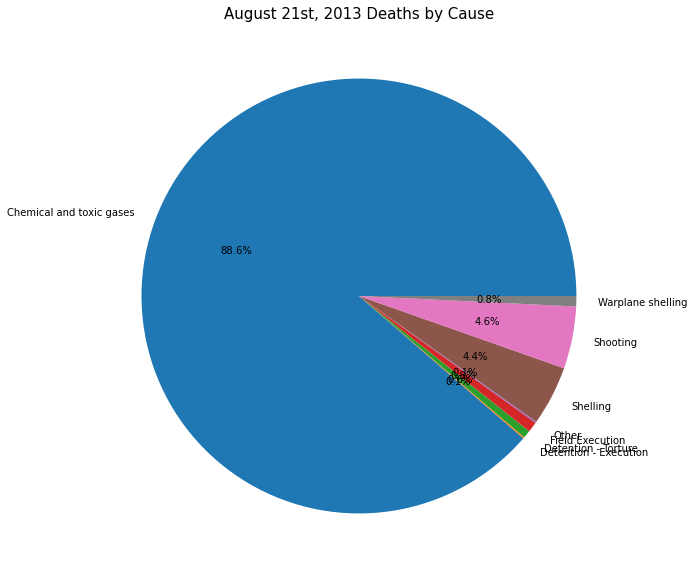

In [151]:
plt.figure(figsize=(10,10)) 
plt.title('August 21st, 2013 Deaths by Cause', fontsize=15)
plt.pie(GhoutaStatsThree['count'],labels=GhoutaStatsThree['deathcause'],autopct='%1.1f%%')
plt.show()

The three pie charts very interestingly shows the great significance of the chemical attack. The casualties were very predominantly civilian and indeed by a lethal gas. While the vast majority of deaths could not be attributed, the only other perpetrator identified on that day were Syrian government forces. The lack of any other identifiable perpetrator on that day may be the reason why the chemical attack has been attributed to the Syrian government. 

That is just one incident however. Let's overall compare casualties caused by different factions.

In [154]:
FactionKills = data.groupby(['actor']).name.agg('count').to_frame('count').reset_index()
FactionKills

,actor,count
0,Al-Nusra Front,229
1,Armed opposition groups,2059
2,International coalition forces,2404
3,Not identified,129862
4,Russian troops,4013
5,Self administration forces,672
6,Syrian government and affiliated militias,22007
7,The organization of the Islamic State in Iraq ...,7180


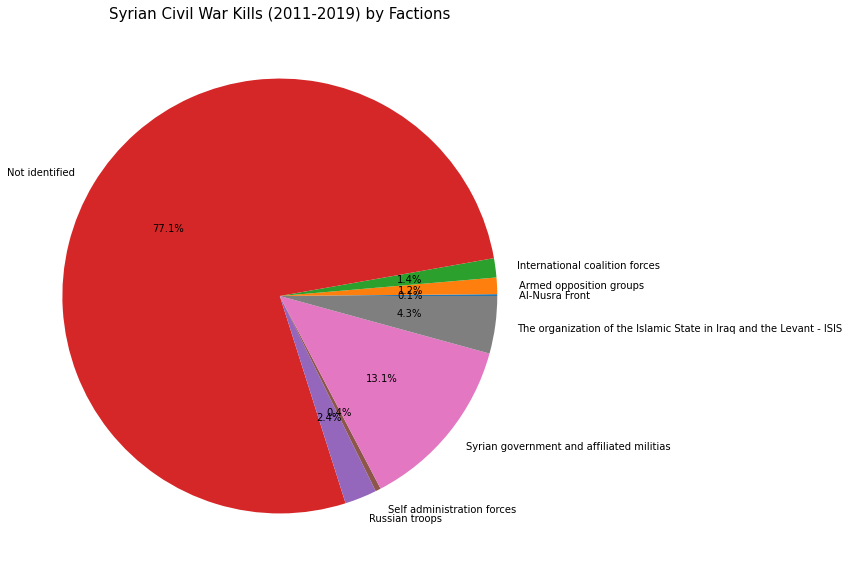

In [155]:
plt.figure(figsize=(10,10)) 
plt.title('Syrian Civil War Kills (2011-2019) by Factions', fontsize=15)
plt.pie(FactionKills['count'],labels=FactionKills['actor'],autopct='%1.1f%%')
plt.show()

Most casualties have an unknown perpetrator, which is surprising. This may be because of civilians being the vast majority of the casualties as shown before. I hypothesize that civilians are more likely to have unidentified killers than non-civilians due to that reasoning, but let's test that out. Lets create two similar datasets, but between civilians and non-civilians.

In [156]:
CivilianCas = data.loc[data['status'] == "Civilian"]
NonCivilianCas = data.loc[data['status'] == "Non-Civilian"]

CivilianCasActor = CivilianCas.groupby(['actor']).name.agg('count').to_frame('count').reset_index()
NonCivilianCasActor = NonCivilianCas.groupby(['actor']).name.agg('count').to_frame('count').reset_index()

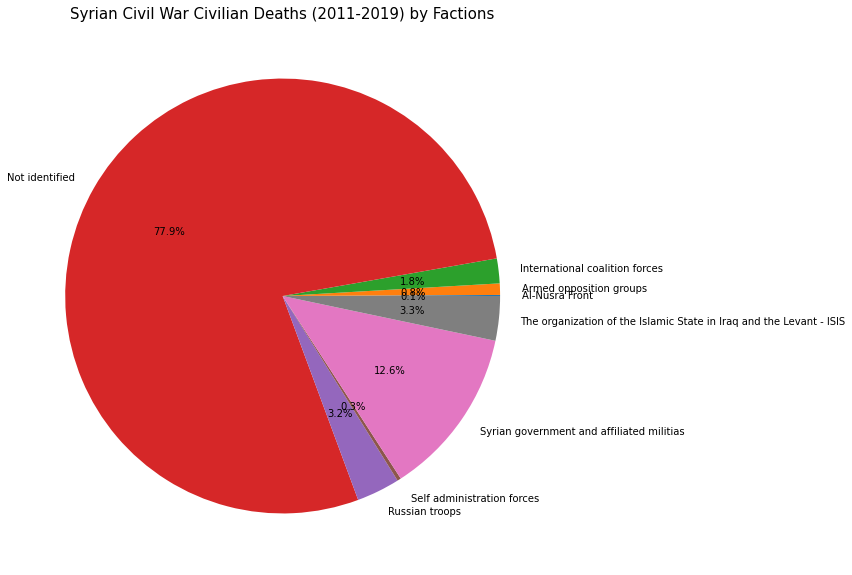

In [158]:
plt.figure(figsize=(10,10)) 
plt.title('Syrian Civil War Civilian Deaths (2011-2019) by Factions', fontsize=15)
plt.pie(CivilianCasActor['count'],labels=CivilianCasActor['actor'],autopct='%1.1f%%')
plt.show()

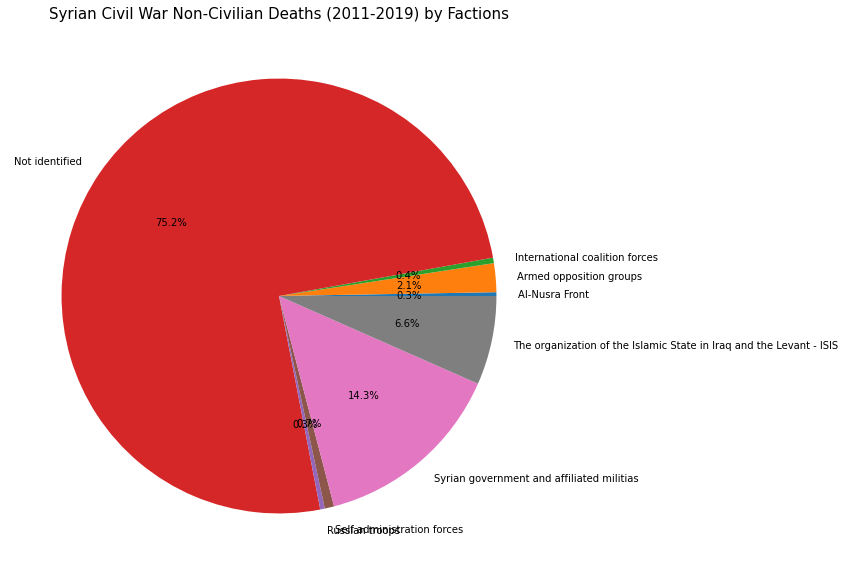

In [160]:
plt.figure(figsize=(10,10)) 
plt.title('Syrian Civil War Non-Civilian Deaths (2011-2019) by Factions', fontsize=15)
plt.pie(NonCivilianCasActor['count'],labels=NonCivilianCasActor['actor'],autopct='%1.1f%%')
plt.show()

To my own surprise, the distributions are quite similar to one another. With such a large proportion, we can't really check the differences between casualties where the actor was identified. Let's modify the datasets so they only take in identified data.

# Machine Learning

Linear Regression line stuff

In [170]:
data_timeplot_regress = data_timeplot
data_timeplot_regress["deathdate"] = data_timeplot_regress['deathdate'].map(dt.datetime.toordinal) # convert 
est = ols(formula = 'deathdate ~ count', data = data_timeplot_regress).fit()
print(est.summary())

                            OLS Regression Results                            
Dep. Variable:              deathdate   R-squared:                       0.128
Model:                            OLS   Adj. R-squared:                  0.128
Method:                 Least Squares   F-statistic:                     421.1
Date:                Sun, 19 Dec 2021   Prob (F-statistic):           2.14e-87
Time:                        07:29:15   Log-Likelihood:                -23058.
No. Observations:                2858   AIC:                         4.612e+04
Df Residuals:                    2856   BIC:                         4.613e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    7.36e+05     21.458   3.43e+04      0.0

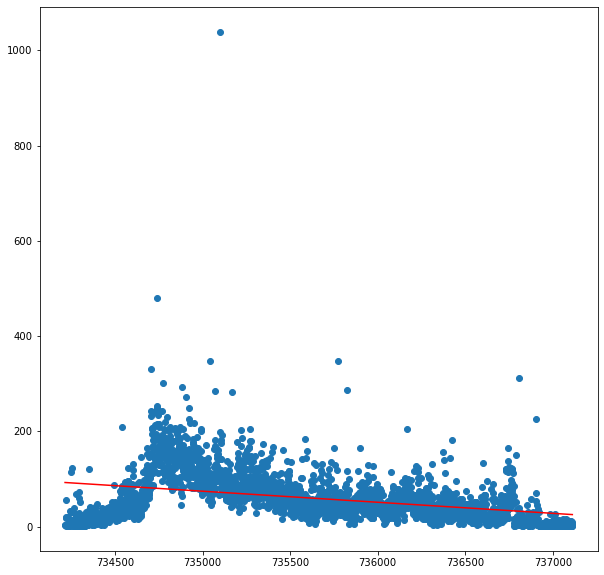

In [172]:
X = data_timeplot_regress['deathdate'].values.reshape(-1, 1)
Y = data_timeplot_regress['count'].values.reshape(-1, 1)
linear_regressor = LinearRegression()
linear_regressor.fit(X, Y)
Y_pred = linear_regressor.predict(X)

plt.figure(figsize=(10,10)) 

plt.scatter(X, Y)
plt.plot(X, Y_pred, color='red') # plots regression line
plt.show()